In [85]:
import nest
import numpy
import matplotlib.pyplot as plt

import nest
import numpy

nest.ResetKernel()

# Set simulation kernel
nest.SetKernelStatus({
  "local_num_threads": 1,
  "resolution": 0.1,
  "rng_seed": 1
})

# Create nodes
n1 = nest.Create("iaf_psc_alpha", 300, params={
  "C_m": 30,
  "E_L": -70,
  "V_reset": -70,
  "V_th": -60,
  "t_ref": 2,
  "tau_m": 20,
  "tau_syn_ex": 1,
  "tau_syn_in": 10,
})
n2 = nest.Create("iaf_psc_alpha", 500, params={
  "C_m": 30,
  "E_L": -70,
  "V_reset": -70,
  "V_th": -60,
  "t_ref": 2,
  "tau_m": 20,
  "tau_syn_ex": 1,
  "tau_syn_in": 10,
})
pg1 = nest.Create("poisson_generator", 1, params={
  "rate": 800,
})
sr1 = nest.Create("spike_recorder", 1, params={
  "start": 0,
  "stop": 1000,
})
sr2 = nest.Create("spike_recorder", 1, params={
  "start": 0,
  "stop": 1000,
})
dc1 = nest.Create("dc_generator", 1, params={
  "amplitude": -180,
  "start": 600,
  "stop": 1000,
})
pg2 = nest.Create("poisson_generator", 1, params={
  "rate": 800,
  "start": 800,
  "stop": 1000,
})

# Connect nodes
nest.Connect(n1, n1, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 50,
}, syn_spec={ 
  "weight": 50,
  "delay": 2,
})
nest.Connect(n2, n2, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 30,
}, syn_spec={ 
  "weight": -5,
  "delay": 2,
})
nest.Connect(n1, n2, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 50,
}, syn_spec={ 
  "weight": 30,
  "delay": 5,
})
nest.Connect(n2, n1, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 30,
}, syn_spec={ 
  "weight": -15,
  "delay": 5,
})
nest.Connect(pg1, n2, syn_spec={ 
  "weight": 40,
})
nest.Connect(n1, sr1)
nest.Connect(n2, sr2)
nest.Connect(dc1, n1)
nest.Connect(pg1, n1, syn_spec={ 
  "weight": 65,
})
nest.Connect(pg2, n2, syn_spec={ 
  "weight": -5,
})

# Tag annotations
nest.userdict.clear()
nest.userdict["STN -excitatory"] = n1
nest.userdict["GPe -inhibitory"] = n2

# Run simulation
nest.Simulate(1000)

response = {
  "events": [sr1.events, sr2.events, ]
}

  
#########################################################
events_STN = sr1.events
events_GPe = sr2.events



Jan 28 20:32:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jan 28 20:32:26 NodeManager::prepare_nodes [Info]: 
    Preparing 805 nodes for simulation.

Jan 28 20:32:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 805
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jan 28 20:32:27 SimulationManager::run [Info]: 
    Simulation finished.


In [17]:
events_STN

{'senders': array([ 14, 141, 229, ...,  87,  67, 297]),
 'times': array([  2.8,   3. ,   2.8, ..., 583. , 587.9, 587.3])}

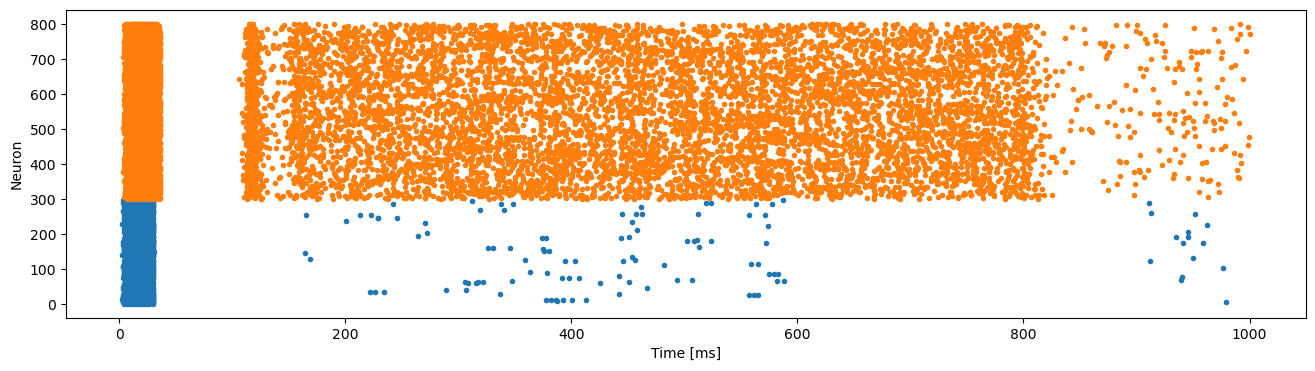

In [86]:
%matplotlib inline
import numpy as np

plt.figure(figsize=(16,4))
plt.scatter(events_STN["times"], events_STN["senders"], marker=".")
plt.scatter(events_GPe["times"], events_GPe["senders"], marker=".")
plt.xlabel("Time [ms]")
plt.ylabel("Neuron")
#plt.show()
plt.plot()
plt.savefig("Nest_1.jpg")

In [87]:
def meanFR(events, start, end):
    return np.sum((events["times"] > start) & (events["times"] < end)) / (end - start)

binSize = 10
totalStart = 0
totalEnd = 1000
meanFR_STN = np.array([meanFR(events_STN, start, start + binSize) for start in range(totalStart, totalEnd)])
meanFR_GPe = np.array([meanFR(events_GPe, start, start + binSize) for start in range(totalStart, totalEnd)])
#print(meanFR_STN)

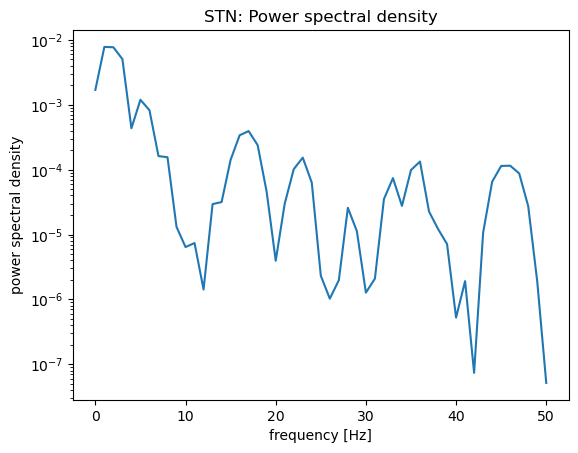

In [89]:
from scipy import signal
# STN: interval 500 - 1000 ms

intervals = [500, 600, 700, 800, 900, 1000]
for start, end in zip(intervals, intervals[1:]):
    freq_STN, ps_dens_STN = signal.welch(meanFR_STN[start:end], 100, nperseg=100)
plt.figure()
plt.semilogy(freq_STN, ps_dens_STN)
plt.xlabel('frequency [Hz]')
plt.ylabel('power spectral density')
plt.title('STN: Power spectral density')
plt.savefig(f'STN_Welch_500_1000.jpg')


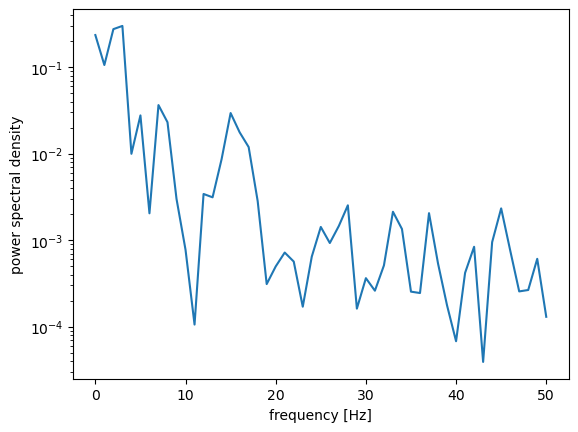

In [84]:
# GPe: interval 500 - 1000
intervals = [500, 600, 700, 800, 900, 1000]
for start, end in zip(intervals, intervals[1:]):
    freq_GPe, ps_dens_GPe = signal.welch(meanFR_GPe[start:end], 100, nperseg=100)
plt.figure()
plt.semilogy(freq_GPe, ps_dens_GPe)
plt.xlabel('frequency [Hz]')
plt.ylabel('power spectral density')
plt.title('STN: Power spectral density')
plt.savefig(f'GPe_Welch_500_1000.jpg')
